In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.stats import sem, t
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler

data_temp = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/tas/mon/v20240514/*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/tasmax/mon/v20240514/*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/tasmin/mon/v20240514/*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/rainfall/mon/v20240514/*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/hurs/mon/v20240514/*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/sun/mon/v20240514/*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/groundfrost/mon/v20240514/*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/psl/mon/v20240514/*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"/Users/maxMax/Desktop/Datasets/12km/sfcWind/mon/v20240514/*.nc", parallel=False)

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(temp_min))
rain_reduced = block_reduce(rain, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(rain))
hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(hurs))
sun_reduced = block_reduce(sun, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(sun))
frost_reduced = block_reduce(frost, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(frost))
psl_reduced = block_reduce(psl, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(psl))
wind_reduced = block_reduce(wind, block_size=(12, 1, 1), func=np.nanmean, cval=np.mean(wind))

min_length = len(wind_reduced)
rain = rain_reduced[:min_length]
hurs = hurs_reduced[:min_length]
temp_reduced = temp_reduced[:min_length]
tmax_reduced = tmax_reduced[:min_length]
tmin_reduced = tmin_reduced[:min_length]
sun = sun_reduced[:min_length]
frost = frost_reduced[:min_length]
wind = wind_reduced[:min_length]
psl = psl_reduced[:min_length]

scaler = MinMaxScaler()

rain = scaler.fit_transform(rain.reshape(-1, 1)).flatten()
hurs = scaler.fit_transform(hurs.reshape(-1, 1)).flatten()
temp_annual_mean = scaler.fit_transform(temp_reduced.reshape(-1, 1)).flatten()
tmax_annual_mean = scaler.fit_transform(tmax_reduced.reshape(-1, 1)).flatten()
tmin_annual_mean = scaler.fit_transform(tmin_reduced.reshape(-1, 1)).flatten()
sun = scaler.fit_transform(sun.reshape(-1, 1)).flatten()
frost = scaler.fit_transform(frost.reshape(-1, 1)).flatten()
psl = scaler.fit_transform(psl.reshape(-1, 1)).flatten()
wind = scaler.fit_transform(wind.reshape(-1, 1)).flatten()

num_years_temp, x, y = temp.shape

years_expanded = np.repeat(np.arange(1969, 2024), x * y)#creating array of years to match shape of reshaped variable array

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Minimum Temperature': tmin_annual_mean,
    'Rainfall': rain,
    'Humidity': hurs,
    'Ground Frost': frost,
    'Sunshine': sun,
    'Mean Sea Level Pressure': psl,
    'Wind Speed': wind
}

df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/skimage/measure/block.py:94: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)), **func_kwargs)


      Temperature  Maximum Temperature  Minimum Temperature  Rainfall  \
Year                                                                    
1969     0.503426             0.530206             0.397075  0.206201   
1969     0.468754             0.488834             0.374230  0.285399   
1969     0.403725             0.418405             0.330685  0.361791   
1969     0.504662             0.416012             0.552804  0.600053   
1969     0.444493             0.364900             0.520948  0.604745   
...           ...                  ...                  ...       ...   
2023     0.625800             0.586654             0.554469  0.243006   
2023     0.750790             0.725636             0.643490  0.178573   
2023     0.796019             0.781599             0.675194  0.132050   
2023     0.767792             0.744276             0.659868  0.144116   
2023     0.570708             0.500501             0.553206  0.414404   

      Humidity  Ground Frost  Sunshine  Mean Sea L

Average Accuracy: 0.6793
95% Confidence Interval: (0.6042670273899153, 0.7542662941472431)


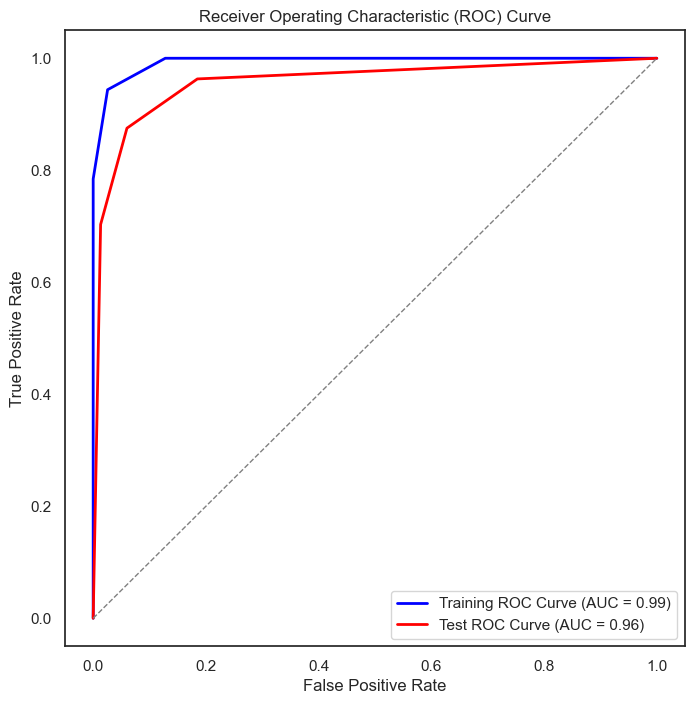

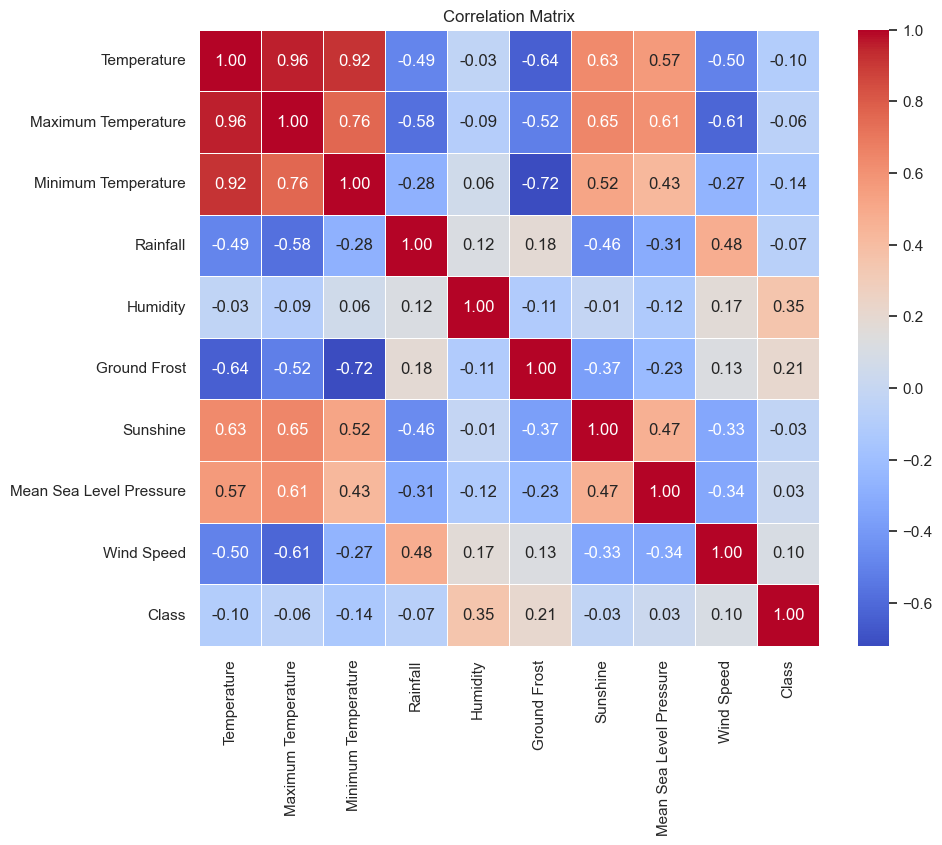

In [30]:
scores = cross_val_score(knn, X, y, cv=5)  #5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)


le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

#predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

#compute ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

auc_train = auc(fpr_train, tpr_train)#calculating area under curve
auc_test = auc(fpr_test, tpr_test)
#plotting
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

correlation_matrix = df.corr()
sns.set(style="white")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The mean values of the classes are 0.8471223866572704 0.08598280343931212
The standard deviations of the classes are 0.2678622697892983 0.2011094452034926


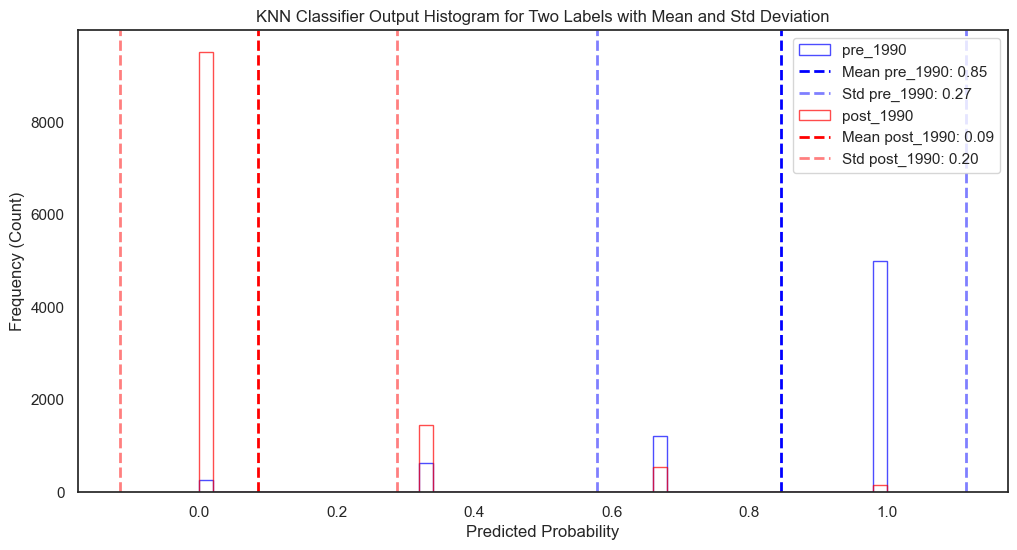

In [27]:
label_1 = 'pre_1990'
label_2 = 'post_1990'

#filter dataframe for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

#mean and std dev values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

plt.figure(figsize=(12, 6))

#histogram for abel 1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# histogram for laabe 2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('KNN Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

In [28]:
z = (mean_label_1 - mean_label_2) / np.sqrt((std_label_1 **2) + (std_label_2 **2))

print('The Z-score for the nominal KNN classifier is', z)

The Z-score for the nominal KNN classifier is 2.272360130523962


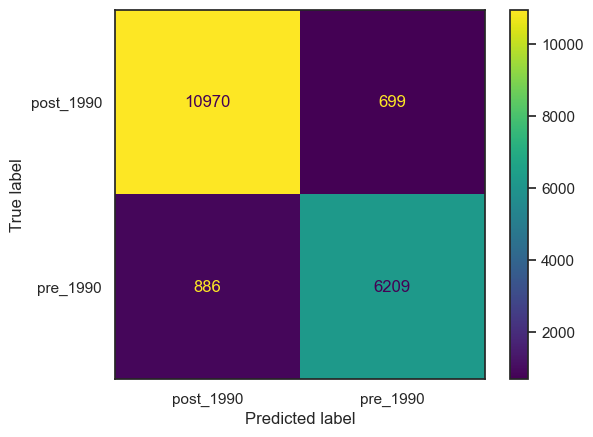

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=knn.classes_).plot()
plt.show()


In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=5)
print(f"Mean Accuracy: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")


Mean Accuracy: 0.6793, Std Dev: 0.0540
